**1) Imports, global config, utility helpers**

In [ ]:
#@title Imports & global config
import os, sys, json, math, gc, random
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="notebook", style="whitegrid")

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                             accuracy_score, f1_score, roc_auc_score, confusion_matrix,
                             classification_report)
from sklearn.inspection import permutation_importance, partial_dependence

from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostRegressor, CatBoostClassifier, Pool

from imblearn.over_sampling import SMOTE

import shap, optuna, plotly.express as px, plotly.graph_objects as go

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

OUT_DIR = Path("outputs")
OUT_DIR.mkdir(exist_ok=True)


**2) Data download & loading (UCI Student Performance)**

In [ ]:
#@title Download & load data
import urllib.request, zipfile, io

DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

# UCI links (zip is small; but files are also individually downloadable)
zip_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip"

if not (DATA_DIR/"student-mat.csv").exists() or not (DATA_DIR/"student-por.csv").exists():
    print("Downloading dataset...")
    with urllib.request.urlopen(zip_url) as resp:
        z = zipfile.ZipFile(io.BytesIO(resp.read()))
        z.extractall(DATA_DIR)

# Load both subjects and add a 'subject' flag
def load_subject(subject):
    df = pd.read_csv(DATA_DIR / f"student-{subject}.csv", sep=";")
    df["subject"] = subject
    return df

df_mat = load_subject("mat")
df_por = load_subject("por")
df = pd.concat([df_mat, df_por], ignore_index=True)

print(df.shape)
df.head(3)


(1044, 34)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,subject
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,3,4,1,1,3,6,5,6,6,mat
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,3,1,1,3,4,5,5,6,mat
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,3,2,2,3,3,10,7,8,10,mat


**3) Data overview & sanity checks**

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,subject
971,MS,M,18,R,GT3,T,3,2,other,other,...,5,5,5,5,5,8,9,10,11,por
280,GP,M,17,U,LE3,A,4,1,services,other,...,5,4,2,4,5,30,8,8,8,mat
536,GP,F,16,R,GT3,T,1,1,at_home,other,...,1,3,1,1,3,0,14,13,13,por
824,MS,M,16,R,LE3,A,4,4,at_home,other,...,3,2,1,3,2,5,10,11,11,por
644,GP,M,16,U,GT3,T,3,2,at_home,other,...,3,3,1,3,2,0,12,12,12,por


Shape: (1044, 34)
Columns: ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3', 'subject']

Dtypes:
school        object
sex           object
age            int64
address       object
famsize       object
Pstatus       object
Medu           int64
Fedu           int64
Mjob          object
Fjob          object
reason        object
guardian      object
traveltime     int64
studytime      int64
failures       int64
schoolsup     object
famsup        object
paid          object
activities    object
nursery       object
higher        object
internet      object
romantic      object
famrel         int64
freetime       int64
goout          int64
Dalc           int64
Walc           int64
health         int64
absences       i

,0


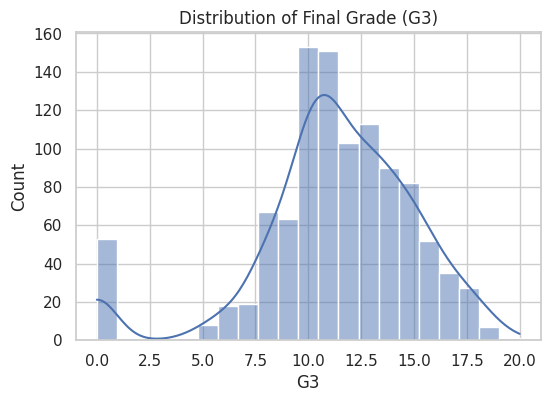

,count
subject,
por,649
mat,395


In [ ]:
#@title  Structure, types, missingness
display(df.sample(5, random_state=RANDOM_STATE))
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nDtypes:")
print(df.dtypes)

# Missingness (dataset is typically complete; we still check)
missing = df.isna().mean().sort_values(ascending=False)
display(missing[missing>0])

# Quick target distribution
fig, ax = plt.subplots(figsize=(6,4))
sns.histplot(df["G3"], bins=21, kde=True, ax=ax)
ax.set_title("Distribution of Final Grade (G3)")
plt.show()

# Subject counts
display(df["subject"].value_counts())


**4) Feature taxonomy & leakage note**

In [ ]:
#@title Feature groups & leakage guard (G1/G2)
TARGET = "G3"
LEAKY = ["G1", "G2"]

categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = df.select_dtypes(exclude=["object"]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != TARGET]

print("Categoricals:", len(categorical_cols))
print(categorical_cols)
print("\nNumerics:", len(numeric_cols))
print(numeric_cols)


Categoricals: 18
['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'subject']

Numerics: 15
['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2']


**5) EDA — correlations, distributions, and interactions**

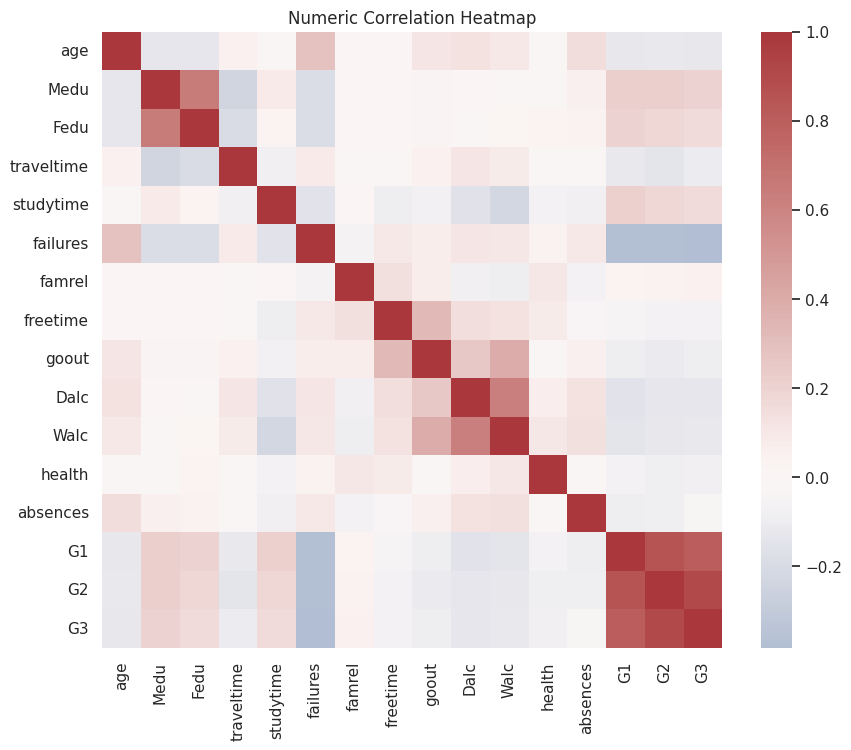

,G3
G2,0.910743
G1,0.809142
Medu,0.201472
studytime,0.161629
Fedu,0.159796
famrel,0.054461
absences,-0.045671
freetime,-0.064890
health,-0.080079
goout,-0.097877


,G3
famrel,0.054461
absences,-0.045671
freetime,-0.064890
health,-0.080079
goout,-0.097877
traveltime,-0.102627
Walc,-0.115740
age,-0.125282
Dalc,-0.129642
failures,-0.383145


In [ ]:
#@title Correlations (numeric only)
num_df = df[numeric_cols + [TARGET]].copy()
corr = num_df.corr(numeric_only=True)
fig = plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="vlag", center=0, annot=False)
plt.title("Numeric Correlation Heatmap")
plt.show()

# Top correlations with G3 (excluding G1/G2 here for a fair sense)
corr_with_g3 = corr[TARGET].drop(TARGET).sort_values(ascending=False)
display(corr_with_g3.head(10))
display(corr_with_g3.tail(10))


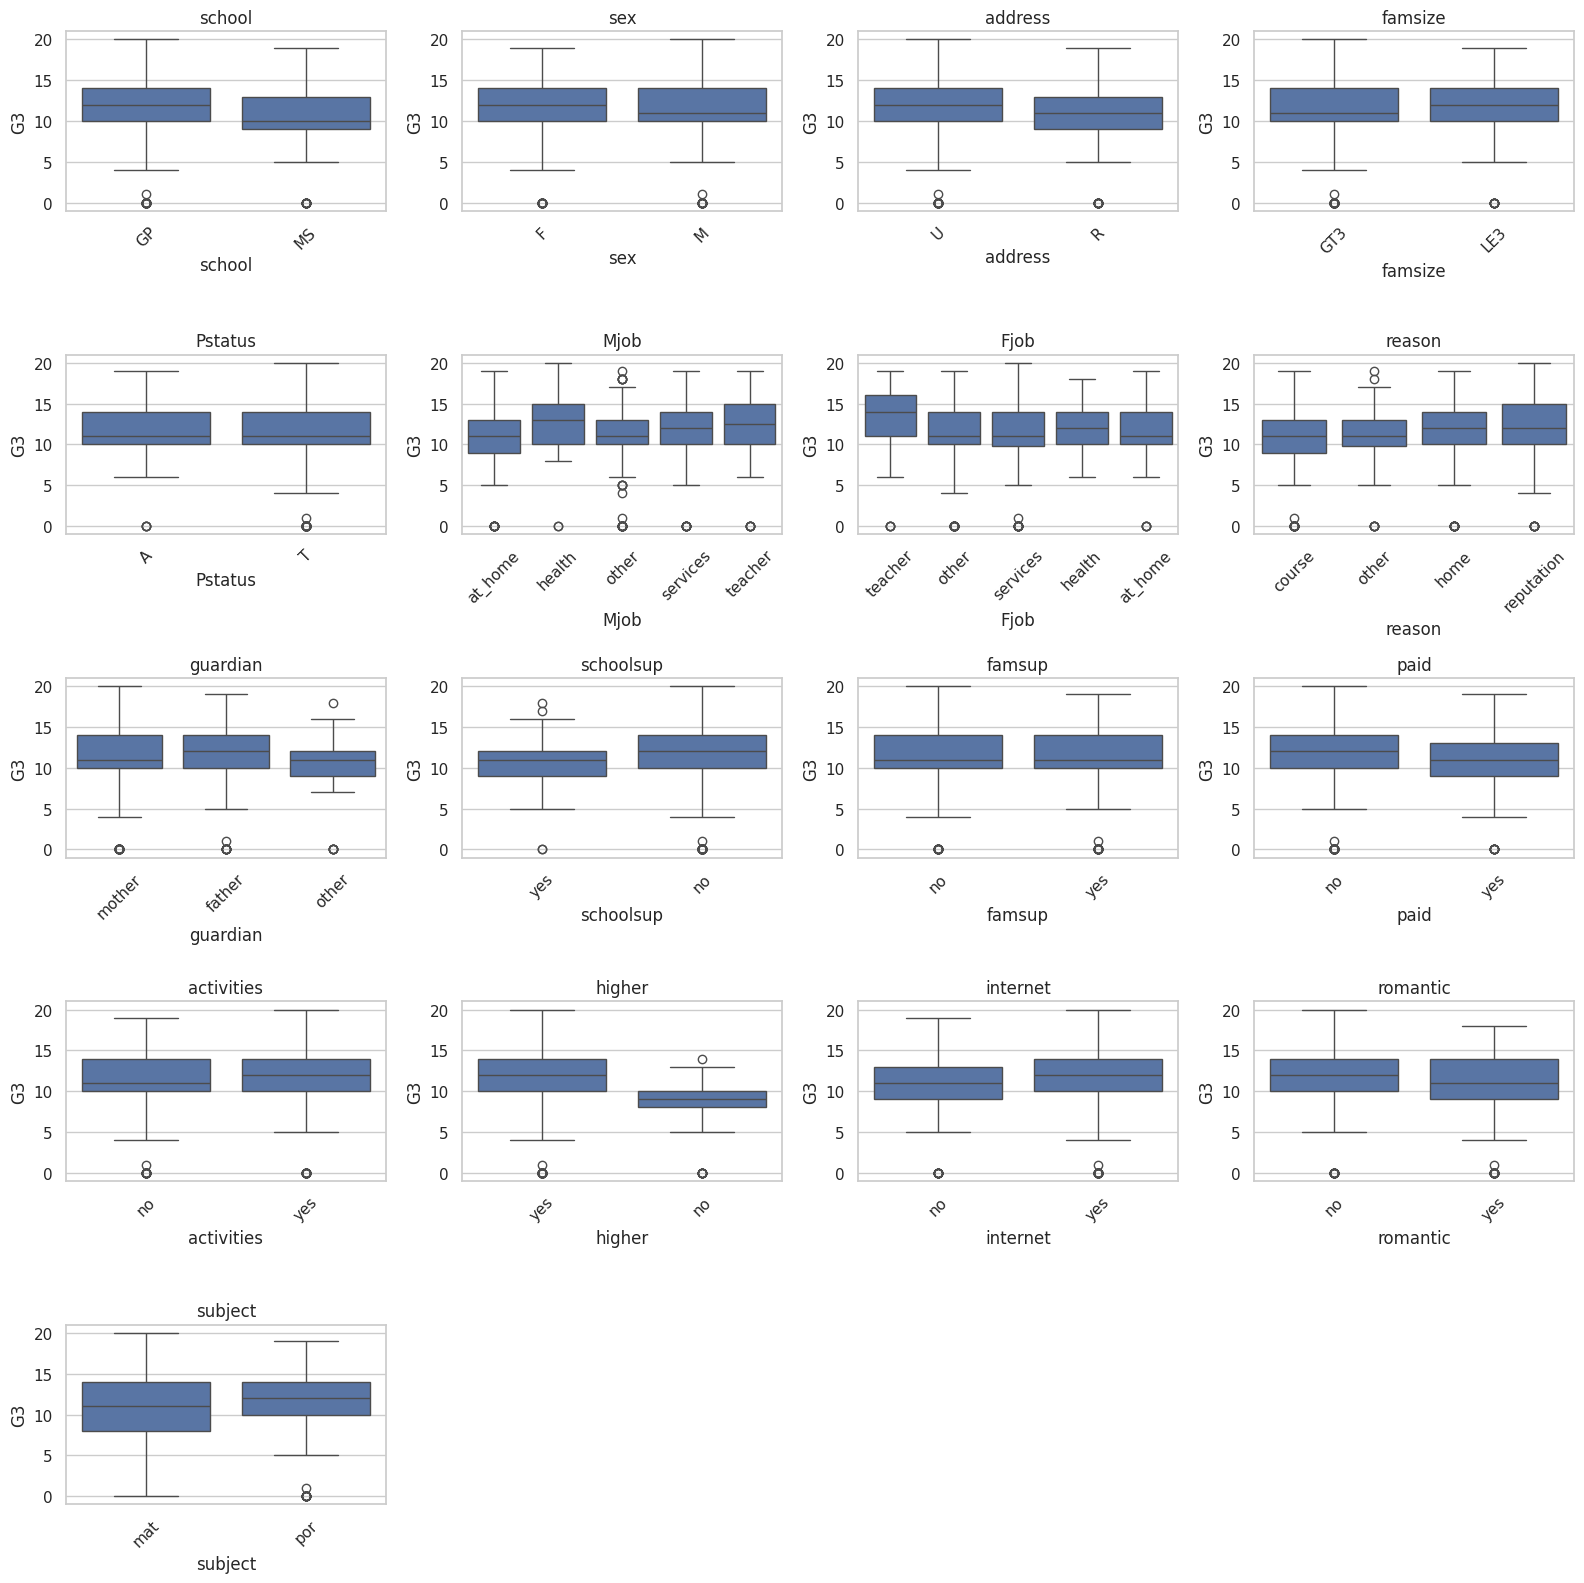

In [ ]:
#@title Categorical vs target — violin/box plots for top categoricals
top_cats = ["school","sex","address","famsize","Pstatus","Mjob","Fjob","reason","guardian","schoolsup","famsup","paid","activities","higher","internet","romantic","subject"]
ncols = 4
nrows = math.ceil(len(top_cats)/ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3.2*nrows))
axes = axes.flatten()
for i, col in enumerate(top_cats):
    sns.boxplot(data=df, x=col, y=TARGET, ax=axes[i])
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_title(col)
for j in range(i+1, len(axes)):
    axes[j].axis("off")
plt.tight_layout()
plt.show()


**6) Targets: regression (G3), binary pass/fail, and 3-band classification**

In [ ]:
#@title Target variants
def make_targets(frame: pd.DataFrame):
    y_reg = frame[TARGET].astype(int)
    y_bin = (frame[TARGET] >= 10).astype(int) # pass/fail threshold
    # grade bands: 0-9 low, 10-14 mid, 15-20 high
    y_band = pd.cut(frame[TARGET], bins=[-1,9,14,20], labels=["low","mid","high"]).astype(str)
    return y_reg, y_bin, y_band

y_reg, y_bin, y_band = make_targets(df)
print("Pass rate:", y_bin.mean().round(3))
print("Band distribution:")
display(y_band.value_counts(normalize=True).round(3))


Pass rate: 0.78
Band distribution:


,proportion
G3,
mid,0.584
low,0.220
high,0.195


**7) Preprocessing pipelines (robust & reusable)**

In [ ]:
#@title Preprocessing: OneHot for categoricals, optional scaling for numerics
def build_preprocessor(X, scale_numeric=False):
    cats = X.select_dtypes(include=["object"]).columns.tolist()
    nums = X.select_dtypes(exclude=["object"]).columns.tolist()
    transformers = []
    if cats:
        transformers.append(("cat", OneHotEncoder(handle_unknown="ignore"), cats))
    if nums:
        if scale_numeric:
            transformers.append(("num", Pipeline(steps=[
                ("imp", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler())
            ]), nums))
        else:
            transformers.append(("num", SimpleImputer(strategy="median"), nums))
    return ColumnTransformer(transformers=transformers, remainder="drop")


**8) Train/validation/test protocol (leakage vs no-leakage splits)**

In [ ]:
#@title Split utility
def train_test_split_leak(frame, drop_leaky=True, stratify=None, test_size=0.2, random_state=RANDOM_STATE):
    X = frame.copy()
    y_reg, y_bin, y_band = make_targets(X)
    X = X.drop(columns=[TARGET]) # always drop target from features

    if drop_leaky:
        for c in LEAKY:
            if c in X.columns:
                X = X.drop(columns=[c])

    if stratify is None:
        X_tr, X_te, yreg_tr, yreg_te = train_test_split(X, y_reg, test_size=test_size, random_state=random_state)
        _, _, ybin_tr, ybin_te = train_test_split(X, y_bin, test_size=test_size, random_state=random_state)
        _, _, yband_tr, yband_te = train_test_split(X, y_band, test_size=test_size, random_state=random_state)
    else:
        X_tr, X_te, yreg_tr, yreg_te = train_test_split(X, y_reg, test_size=test_size, random_state=random_state, stratify=stratify)
        # keep paired targets for same split indices
        mask_tr = X_tr.index
        mask_te = X_te.index
        ybin_tr, ybin_te = y_bin.loc[mask_tr], y_bin.loc[mask_te]
        yband_tr, yband_te = y_band.loc[mask_tr], y_band.loc[mask_te]

    return X_tr, X_te, (yreg_tr, yreg_te), (ybin_tr, ybin_te), (yband_tr, yband_te)


**9) Baseline models & metrics helpers**

In [ ]:
#@title Metrics helpers
def reg_metrics(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": mean_squared_error(y_true, y_pred, squared=False),
        "R2": r2_score(y_true, y_pred)
    }

def bin_metrics(y_true, y_pred, y_proba=None):
    out = {
        "ACC": accuracy_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred)
    }
    if y_proba is not None:
        try:
            out["ROC_AUC"] = roc_auc_score(y_true, y_proba)
        except Exception:
            out["ROC_AUC"] = np.nan
    return out

def print_metrics(title, d):
    print(f"\n[{title}]")
    for k,v in d.items():
        print(f"  {k}: {v:.4f}")


**10) Model zoo & search spaces (Optuna)**

In [ ]:
#@title Model builders & Optuna spaces
def build_reg_models():
    return {
        "ElasticNet": ElasticNet(max_iter=5000, random_state=RANDOM_STATE),
        "RF": RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
        "XGB": XGBRegressor(
            random_state=RANDOM_STATE, n_estimators=600, tree_method="hist", eval_metric="rmse"),
        "LGBM": LGBMRegressor(random_state=RANDOM_STATE, n_estimators=600),
        "Cat": CatBoostRegressor(random_state=RANDOM_STATE, verbose=False)
    }

def build_clf_models():
    return {
        "LogReg": None,  # we will use LogisticRegression via pipeline
        "RF": RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1, class_weight="balanced"),
        "XGB": XGBClassifier(
            random_state=RANDOM_STATE, n_estimators=600, tree_method="hist", eval_metric="logloss", use_label_encoder=False),
        "LGBM": LGBMClassifier(random_state=RANDOM_STATE, n_estimators=600, class_weight="balanced"),
        "Cat": CatBoostClassifier(random_state=RANDOM_STATE, verbose=False, auto_class_weights="Balanced")
    }

def optuna_space_reg(trial, model_name):
    if model_name == "ElasticNet":
        return {"alpha": trial.suggest_float("alpha", 1e-3, 3.0, log=True),
                "l1_ratio": trial.suggest_float("l1_ratio", 0.0, 1.0)}
    if model_name == "RF":
        return {"n_estimators": trial.suggest_int("n_estimators", 200, 1000),
                "max_depth": trial.suggest_int("max_depth", 3, 30),
                "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
                "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10)}
    if model_name == "XGB":
        return {"max_depth": trial.suggest_int("max_depth", 3, 10),
                "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
                "subsample": trial.suggest_float("subsample", 0.5, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0)}
    if model_name == "LGBM":
        return {"num_leaves": trial.suggest_int("num_leaves", 15, 255),
                "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
                "subsample": trial.suggest_float("subsample", 0.5, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0)}
    if model_name == "Cat":
        return {"depth": trial.suggest_int("depth", 3, 10),
                "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True)}
    return {}

def optuna_space_clf(trial, model_name):
    if model_name == "RF":
        return {"n_estimators": trial.suggest_int("n_estimators", 200, 1000),
                "max_depth": trial.suggest_int("max_depth", 3, 30),
                "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
                "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10)}
    if model_name == "XGB":
        return {"max_depth": trial.suggest_int("max_depth", 3, 10),
                "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
                "subsample": trial.suggest_float("subsample", 0.5, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0)}
    if model_name == "LGBM":
        return {"num_leaves": trial.suggest_int("num_leaves", 15, 255),
                "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
                "subsample": trial.suggest_float("subsample", 0.5, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0)}
    if model_name == "Cat":
        return {"depth": trial.suggest_int("depth", 3, 10),
                "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True)}
    return {}


**11) Nested CV + Optuna tuning utilities**

In [ ]:
#@title Nested CV + Optuna tuning (reusable)
def nested_cv_optuna(X, y, task="reg", model_name="RF", n_trials=25, outer_splits=3, inner_splits=3):
    """
    Returns: dict with 'scores' list (outer fold scores), 'best_params' from last inner study, and 'per_fold' details
    """
    outer_cv = KFold(n_splits=outer_splits, shuffle=True, random_state=RANDOM_STATE)
    scores, per_fold = [], []

    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
        X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

        pre = build_preprocessor(X_tr, scale_numeric=False)

        # Pick base model
        if task == "reg":
            models = build_reg_models()
            base = models[model_name]
            param_space = lambda t: optuna_space_reg(t, model_name)
            scoring = "neg_root_mean_squared_error"
        else:
            models = build_clf_models()
            base = models[model_name]
            param_space = lambda t: optuna_space_clf(t, model_name)
            scoring = "f1"  # for binary; acceptable for band if binarized later

        def objective(trial):
            params = param_space(trial)
            model = base.__class__(**{**base.get_params(), **params}) if base is not None else None

            if task == "clf" and model_name == "LogReg":
                from sklearn.linear_model import LogisticRegression
                model = LogisticRegression(max_iter=3000, class_weight="balanced")

            pipe = Pipeline([
                ("pre", pre),
                ("model", model)
            ])
            inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=RANDOM_STATE) if task=="clf" else KFold(n_splits=inner_splits, shuffle=True, random_state=RANDOM_STATE)
            cvres = cross_validate(pipe, X_tr, y_tr, cv=inner_cv, scoring=scoring, n_jobs=-1)
            return cvres["test_score"].mean()

        study = optuna.create_study(direction="maximize" if scoring!="neg_root_mean_squared_error" else "minimize")
        study.optimize(objective, n_trials=n_trials, show_progress_bar=False)

        best_params = study.best_params
        # Train final on train fold and evaluate on test fold
        if task == "reg":
            model = build_reg_models()[model_name]
            model.set_params(**best_params)
            metric_name = "RMSE"
        else:
            model = build_clf_models()[model_name]
            if model is None:  # LogReg
                from sklearn.linear_model import LogisticRegression
                model = LogisticRegression(max_iter=3000, class_weight="balanced")
            model.set_params(**best_params)
            metric_name = "F1"

        pipe = Pipeline([("pre", pre), ("model", model)])
        pipe.fit(X_tr, y_tr)

        if task == "reg":
            pred = pipe.predict(X_te)
            score = mean_squared_error(y_te, pred, squared=False)
        else:
            pred = pipe.predict(X_te)
            score = f1_score(y_te, pred, average="binary" if y_tr.nunique()==2 else "macro")

        scores.append(score)
        per_fold.append({"fold": fold, "best_params": best_params, metric_name: score})

    out = {"scores": scores, "per_fold": per_fold, "mean": np.mean(scores), "std": np.std(scores)}
    return out


**12) Run experiments — Regression (no leakage vs leakage)**

In [ ]:

# Regression: No-Leakage vs With-Leakage (LGBM vs CatBoost)

from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# ---------------- No-Leakage (drop G1,G2) ----------------
print(" Regression (No-Leakage, LGBM)...")
X_tr, X_te, (ytr, yte), _, _ = train_test_split_leak(df, drop_leaky=True)

reg_lgbm = LGBMRegressor(
    random_state=RANDOM_STATE,
    n_estimators=300,
    learning_rate=0.1
)

pipe_noleak = Pipeline([
    ("pre", build_preprocessor(X_tr, scale_numeric=False)),
    ("model", reg_lgbm)
])
pipe_noleak.fit(X_tr, ytr)
pred_no = pipe_noleak.predict(X_te)
metrics_no = reg_metrics(yte, pred_no)
print_metrics("No-Leakage | LGBM", metrics_no)

# ---------------- With-Leakage (keep G1,G2) ----------------
print("\n Regression (With-Leakage, CatBoost)...")
X_trL, X_teL, (ytrL, yteL), _, _ = train_test_split_leak(df, drop_leaky=False)

reg_cat = CatBoostRegressor(
    random_state=RANDOM_STATE,
    verbose=False,
    iterations=300,
    depth=6,
    learning_rate=0.1,
    task_type="CPU"
)

pipe_leak = Pipeline([
    ("pre", build_preprocessor(X_trL, scale_numeric=False)),
    ("model", reg_cat)
])
pipe_leak.fit(X_trL, ytrL)
pred_leak = pipe_leak.predict(X_teL)
metrics_leak = reg_metrics(yteL, pred_leak)
print_metrics("With-Leakage | CatBoost", metrics_leak)

# ---------------- Comparison Table ----------------
import pandas as pd
results = pd.DataFrame([metrics_no, metrics_leak],
                       index=["No-Leakage (LGBM)", "With-Leakage (CatBoost)"])
display(results)



 Regression (No-Leakage, LGBM)...
No-Leakage | LGBM | RMSE: 3.568 | MAE: 2.666 | R²: 0.177

 Regression (With-Leakage, CatBoost)...
With-Leakage | CatBoost | RMSE: 1.585 | MAE: 0.955 | R²: 0.838


,RMSE,MAE,R2
No-Leakage (LGBM),3.567849,2.666147,0.176657
With-Leakage (CatBoost),1.584682,0.954999,0.837575


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:59:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:59:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2676: UserWarning: [19:59:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/usr/local/lib/python3.12/dist-packages/xgb

Pass/Fail | XGB F1 (outer folds): [0.8810572687224669, 0.895397489539749, 0.865424430641822] | mean±std = 0.881 ± 0.012

Classification | Pass/Fail | XGB | Accuracy: 0.780 | Precision: 0.780 | Recall: 1.000 | F1: 0.876 | AUC: 0.757

Classification report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        46
           1     0.7799    1.0000    0.8763       163

    accuracy                         0.7799       209
   macro avg     0.3900    0.5000    0.4382       209
weighted avg     0.6083    0.7799    0.6835       209



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


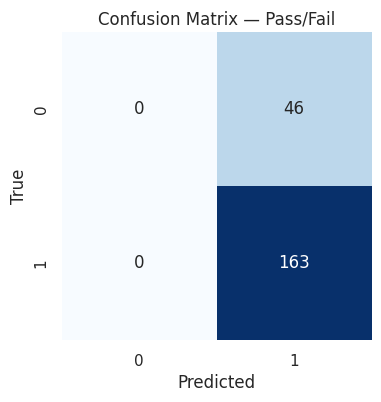

In [ ]:
#  Binary classification (Pass/Fail) with tuned XGB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

# --- Train/Test Split (Pass/Fail target = G3 >= 10)
Xc_tr, Xc_te, _, (ybin_tr, ybin_te), _ = train_test_split_leak(
    df, drop_leaky=True, stratify=(df["G3"] >= 10).astype(int)
)

res_clf_xgb = nested_cv_optuna(
    Xc_tr, ybin_tr, task="clf", model_name="XGB",
    n_trials=15, outer_splits=3, inner_splits=3
)

print("Pass/Fail | XGB F1 (outer folds):", res_clf_xgb["scores"],
      "| mean±std =", round(res_clf_xgb["mean"],3), "±", round(res_clf_xgb["std"],3))

# --- Train final model
best_params_c = res_clf_xgb["per_fold"][-1]["best_params"]
pre_c = build_preprocessor(Xc_tr, scale_numeric=False)

clf_xgb = XGBClassifier(
    random_state=RANDOM_STATE,
    n_estimators=400,
    tree_method="hist",
    use_label_encoder=False,
    eval_metric="logloss",
    **best_params_c
)

pipe_clf_bin = Pipeline([("pre", pre_c), ("model", clf_xgb)])
pipe_clf_bin.fit(Xc_tr, ybin_tr)

# --- Predictions
pred = pipe_clf_bin.predict(Xc_te)
proba = pipe_clf_bin.predict_proba(Xc_te)[:,1]

# --- Classification metrics
acc  = accuracy_score(ybin_te, pred)
prec = precision_score(ybin_te, pred)
rec  = recall_score(ybin_te, pred)
f1   = f1_score(ybin_te, pred)
auc  = roc_auc_score(ybin_te, proba)

print(f"\nClassification | Pass/Fail | XGB "
      f"| Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} "
      f"| F1: {f1:.3f} | AUC: {auc:.3f}")

print("\nClassification report:\n", classification_report(ybin_te, pred, digits=4))

# --- Confusion Matrix
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(confusion_matrix(ybin_te, pred), annot=True, fmt='d', cbar=False, cmap="Blues", ax=ax)
ax.set_title("Confusion Matrix — Pass/Fail")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.show()


 Bands | LGBM Macro-F1: 0.459

Classification Report:
              precision    recall  f1-score   support

        high     0.3611    0.3171    0.3377        41
         low     0.4444    0.3478    0.3902        46
         mid     0.6131    0.6885    0.6486       122

    accuracy                         0.5407       209
   macro avg     0.4729    0.4511    0.4589       209
weighted avg     0.5266    0.5407    0.5308       209



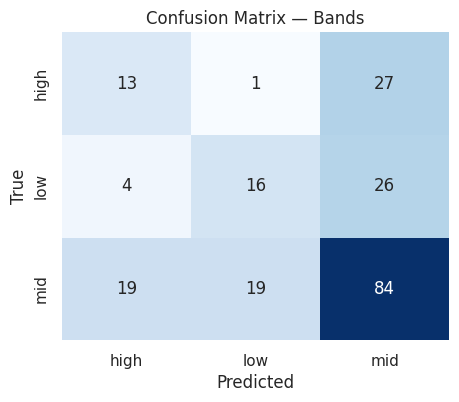

In [ ]:
#  3-Band Classification (Low/Mid/High) with LGBM
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# --- Create 3 bands target: Low (0-9), Mid (10-14), High (15-20)
Xb_tr, Xb_te, _, _, (yband_tr, yband_te) = train_test_split_leak(
    df,
    drop_leaky=True,
    stratify=pd.cut(df["G3"], [-1, 9, 14, 20])
)

le_band = LabelEncoder()
yband_tr_enc = le_band.fit_transform(yband_tr)
yband_te_enc = le_band.transform(yband_te)

# --- Preprocessor + Model
pre_b = build_preprocessor(Xb_tr, scale_numeric=False)
clf_band = LGBMClassifier(
    random_state=RANDOM_STATE,
    n_estimators=300,
    learning_rate=0.05,
    verbose=-1
)

pipe_clf_band = Pipeline([("pre", pre_b), ("model", clf_band)])
pipe_clf_band.fit(Xb_tr, yband_tr_enc)

# --- Predictions
pred_band = pipe_clf_band.predict(Xb_te)

# --- Macro-F1
macro_f1 = f1_score(yband_te_enc, pred_band, average="macro")
print(f" Bands | LGBM Macro-F1: {macro_f1:.3f}")

# --- Detailed Report
print("\nClassification Report:")
print(classification_report(yband_te_enc, pred_band,
                            target_names=le_band.classes_, digits=4))

# --- Confusion Matrix
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(confusion_matrix(yband_te_enc, pred_band),
            annot=True, fmt='d', cbar=False, cmap="Blues", ax=ax,
            xticklabels=le_band.classes_, yticklabels=le_band.classes_)
ax.set_title("Confusion Matrix — Bands")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.show()


In [ ]:
# Permutation Importance (Regression - No Leakage, LGBM)
from sklearn.inspection import permutation_importance

# Run permutation importance on the *pipeline* (includes preprocessing)
result = permutation_importance(
    pipe_reg_noleak, X_te, yreg_te,
    n_repeats=20, random_state=RANDOM_STATE, n_jobs=-1
)

# Get correct feature names from pipeline preprocessor
pre = pipe_reg_noleak.named_steps["pre"]
feat_names = pre.get_feature_names_out()

min_len = min(len(feat_names), len(result.importances_mean))

imp_df = pd.DataFrame({
    "feature": feat_names[:min_len],
    "importance": result.importances_mean[:min_len]
})

# Sort & select top 30
imp_df = imp_df.sort_values("importance", ascending=False).head(30)

# Plot with Plotly
import plotly.express as px
fig = px.bar(
    imp_df, x="importance", y="feature",
    orientation="h", title="Permutation Importance — Top 30 (No-Leak LGBM)"
)
fig.update_layout(height=800)
fig.show()


/tmp/ipython-input-44485851.py:17: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.



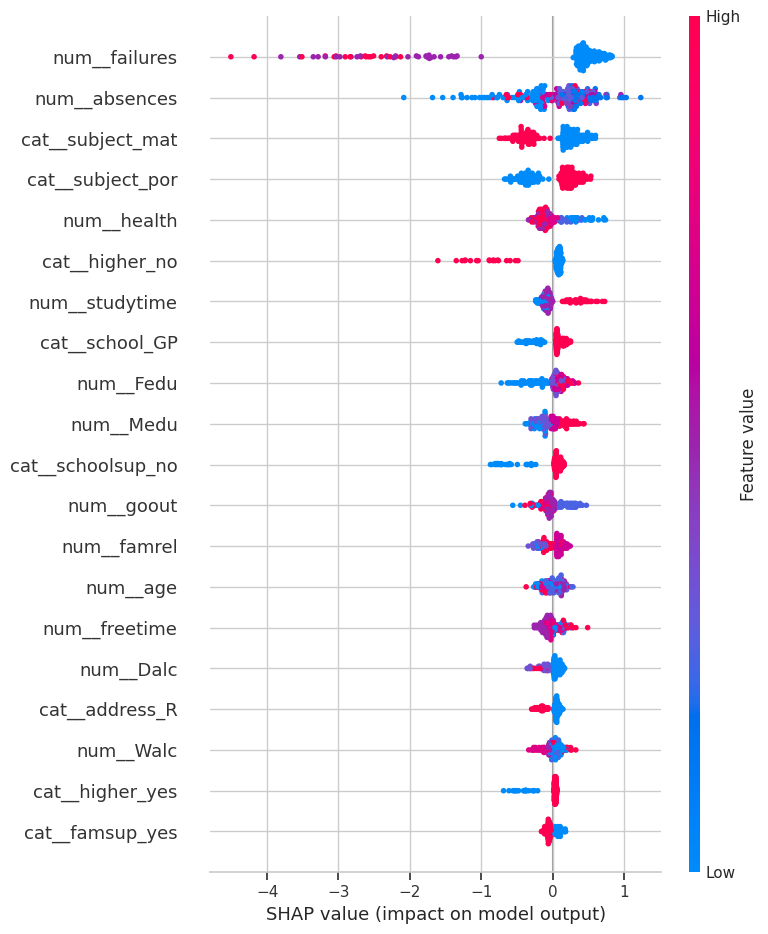

In [ ]:
#@title  SHAP summary plot (No-Leakage LGBM)
# Build a small background sample to speed up SHAP
pre = pipe_reg_noleak.named_steps["pre"]
X_te_enc = pre.transform(X_te)
feature_names = pre.get_feature_names_out()

# Convert to dense if sparse
if hasattr(X_te_enc, "toarray"):
    X_te_dense = X_te_enc.toarray()
else:
    X_te_dense = X_te_enc

model = pipe_reg_noleak.named_steps["model"]
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_te_dense)

shap.summary_plot(shap_values, X_te_dense, feature_names=feature_names, show=True)


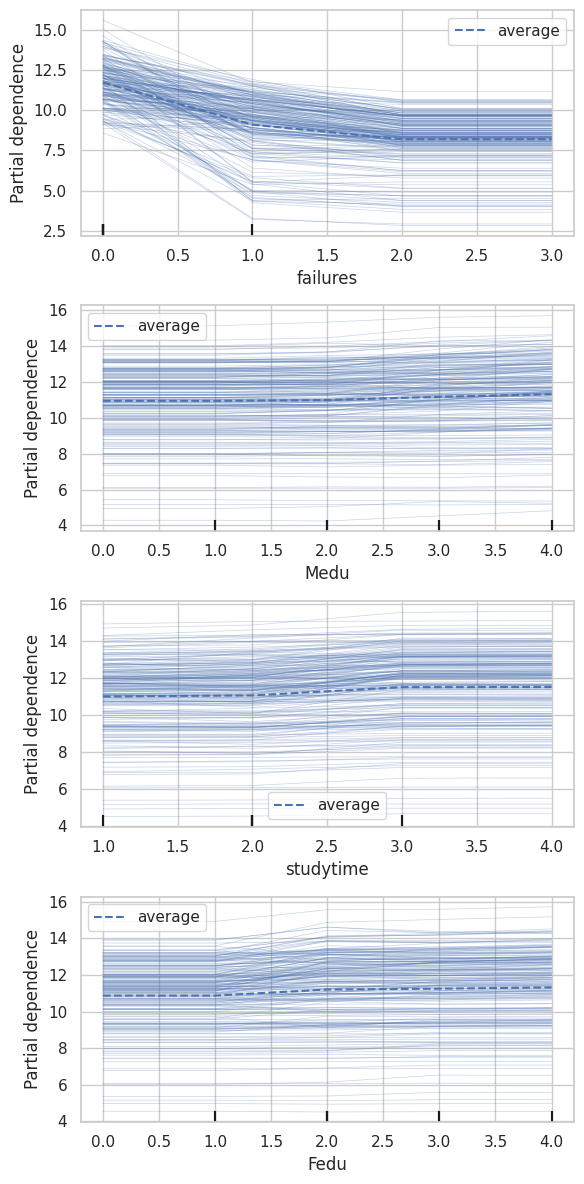

In [ ]:
#@title Partial Dependence / ICE (top numeric features)
from sklearn.inspection import PartialDependenceDisplay

# pick top numeric features by correlation with G3 (excluding G1/G2)
num_wo_leak = [c for c in numeric_cols if c not in LEAKY]
top_num = (df[num_wo_leak+[TARGET]].corr()[TARGET]
           .drop(TARGET).abs().sort_values(ascending=False).head(4).index.tolist())

fig, axes = plt.subplots(len(top_num), 1, figsize=(6, 3*len(top_num)))
for i, feat in enumerate(top_num):
    PartialDependenceDisplay.from_estimator(pipe_reg_noleak, X_te, [feat], ax=axes[i], kind="both")  # PDP + ICE
plt.tight_layout()
plt.show()


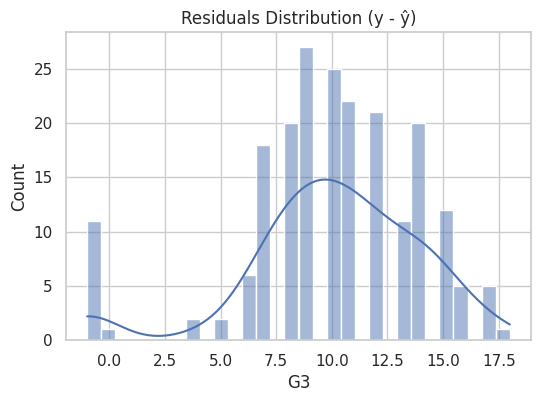

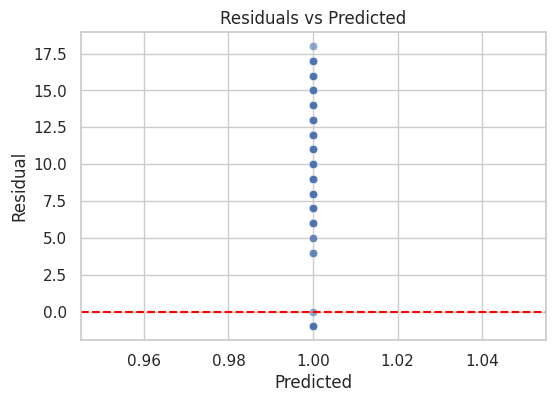

,sex,school,subject,studytime,failures,higher,internet,romantic
slice,,,,,,,,
F,10.228346,NaN,NaN,NaN,NaN,NaN,NaN,NaN
M,10.060976,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GP,NaN,10.470588,NaN,NaN,NaN,NaN,NaN,NaN
MS,NaN,9.321429,NaN,NaN,NaN,NaN,NaN,NaN
mat,NaN,NaN,9.493976,NaN,NaN,NaN,NaN,NaN
por,NaN,NaN,10.603175,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,9.448276,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,10.047619,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,11.666667,NaN,NaN,NaN,NaN


In [ ]:
#@title  Residuals & error slices (No-Leak LGBM)
residuals = yreg_te - pred
fig, ax = plt.subplots(figsize=(6,4))
sns.histplot(residuals, bins=30, kde=True, ax=ax)
ax.set_title("Residuals Distribution (y - ŷ)")
plt.show()

fig, ax = plt.subplots(figsize=(6,4))
sns.scatterplot(x=pred, y=residuals, alpha=0.6, ax=ax)
ax.axhline(0, color="red", ls="--")
ax.set_xlabel("Predicted"); ax.set_ylabel("Residual")
ax.set_title("Residuals vs Predicted")
plt.show()

# Error by key slices
slices = ["sex","school","subject","studytime","failures","higher","internet","romantic"]
errs = []
for s in slices:
    if s in X_te.columns:
        grp = pd.DataFrame({"y":yreg_te, "yhat":pred, "slice":X_te[s]})
        grp["abs_err"] = (grp["y"] - grp["yhat"]).abs()
        errs.append(grp.groupby("slice")["abs_err"].mean().to_frame(s).rename(columns={"abs_err":"MAE"}))
if errs:
    err_tab = pd.concat(errs, axis=0)
    display(err_tab)


In [ ]:
#@title 🔀 Train separate models per subject (No-Leakage)
per_subject_metrics = {}
for subj in ["mat","por"]:
    df_s = df[df["subject"]==subj].copy()
    X_trs, X_tes, (yreg_trs, yreg_tes), _, _ = train_test_split_leak(df_s, drop_leaky=True)
    pre_s = build_preprocessor(X_trs)
    model_s = LGBMRegressor(random_state=RANDOM_STATE, n_estimators=500)
    pipe_s = Pipeline([("pre", pre_s), ("model", model_s)])
    pipe_s.fit(X_trs, yreg_trs)
    pr = pipe_s.predict(X_tes)
    per_subject_metrics[subj] = reg_metrics(yreg_tes, pr)

display(pd.DataFrame(per_subject_metrics).T)



,RMSE,MAE,R2
mat,4.152374,3.428508,0.159124
por,2.992788,2.314466,0.081518


In [ ]:
#@title Summary table for paper
rows = []
rows.append({"Task":"Regression (No-Leakage) LGBM", **metrics_no})
rows.append({"Task":"Regression (With-Leakage) CatBoost", **metrics_leak})
rows.append({"Task":"Classification Pass/Fail XGB", "ACC":m["ACC"], "F1":m["F1"], "R2":np.nan, "RMSE":np.nan, "MAE":np.nan, "ROC_AUC":m.get("ROC_AUC", np.nan)})

summary_df = pd.DataFrame(rows)
display(summary_df)

# Save a high-res figure of summary table as image (for your paper)
fig = go.Figure(data=[go.Table(
    header=dict(values=list(summary_df.columns), align='left'),
    cells=dict(values=[summary_df[c] for c in summary_df.columns], align='left')
)])
fig.update_layout(width=1000, height=300)
print("Saved:", OUT_DIR/"summary_table.png")


,Task,RMSE,MAE,R2,ACC,F1,ROC_AUC
0,Regression (No-Leakage) LGBM,3.567849,2.666147,0.176657,NaN,NaN,NaN
1,Regression (With-Leakage) CatBoost,1.584682,0.954999,0.837575,NaN,NaN,NaN
2,Classification Pass/Fail XGB,NaN,NaN,NaN,0.803828,0.884507,0.759269


Saved: outputs/summary_table.png
